Loading data... 
data mean 0.000000, data variance 1.000000


/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/duys/Documents/machine_learning/lstm_anomaly_thesis/lstm/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (244, 120)                58560     
_________________________________________________________________
dropout_2 (Dropout)          (244, 120)                0         
_________________________________________________________________
dense_2 (Dense)              (244, 1)                  121       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (244, 1, 1)               0         
_________________________________________________________________
activation_2 (Activation)    (244, 1, 1)               0         
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Train on 16836 samples, validate on 976 samples
Resetting states before epoch 0
Epoch 1/40
1s - loss: 0.0979 - val_loss: 0.0102
Resetting 

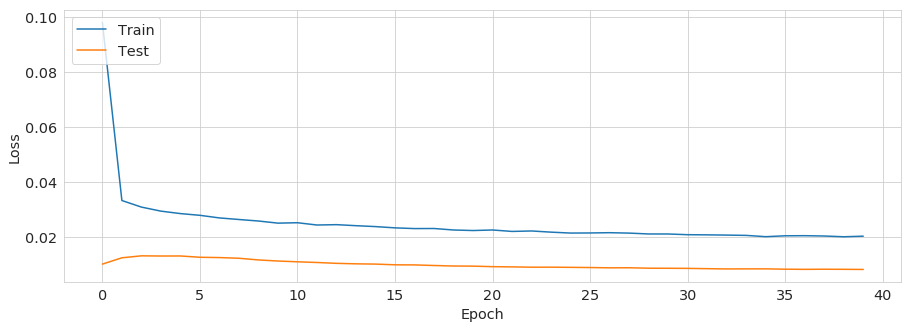

Validation2 Loss 0.07070238412254387
Test Loss 0.07291281471649806
(16836, 1, 1)
((16836,), (16836, 1))


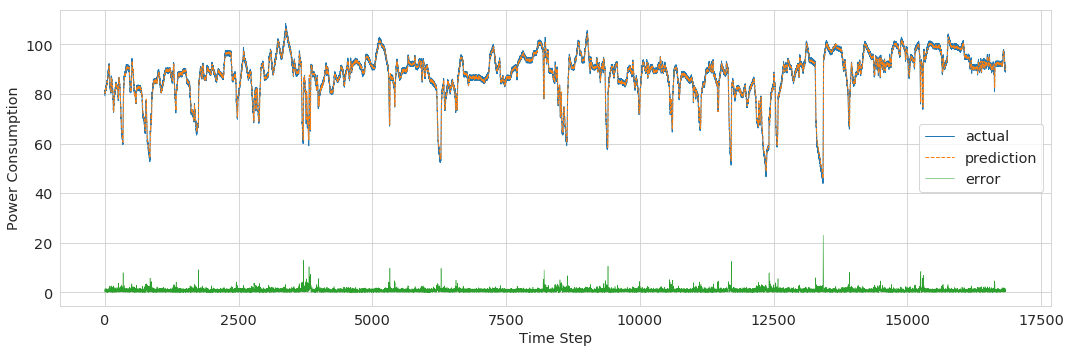

(976, 1, 1)
((976,), (976, 1))


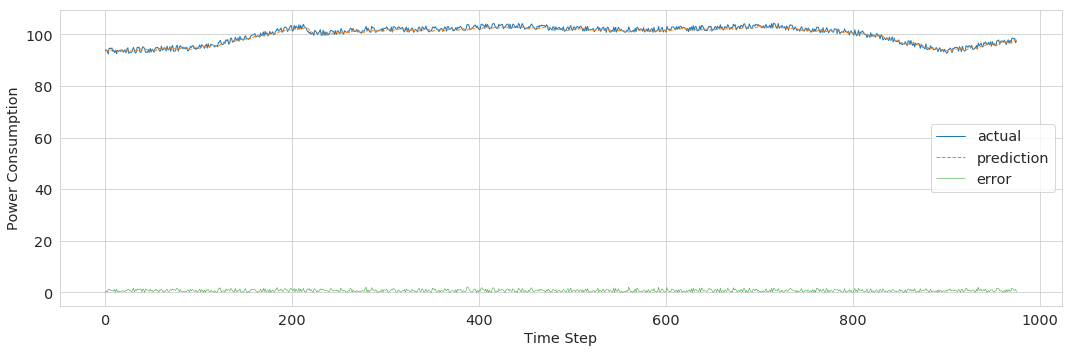

Calculated validation1 loss 0.008280
(2196, 1, 1)
((2196,), (2196, 1))


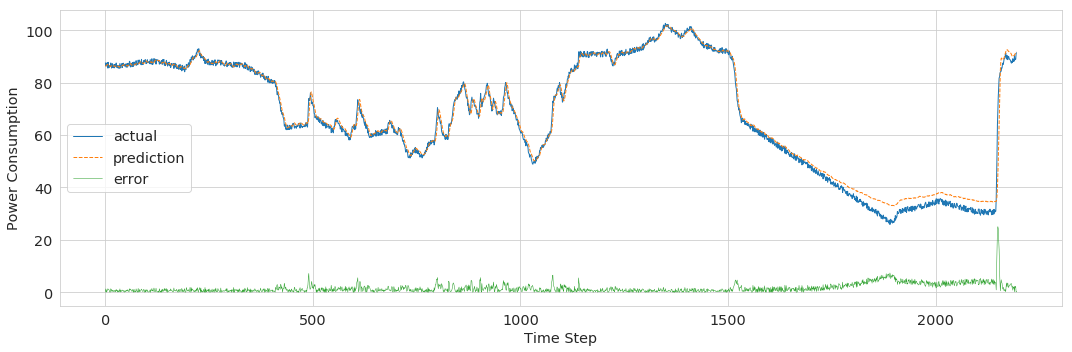

Calculated validation2 loss 0.070702
(2196, 1, 1)
((2196,), (2196, 1))


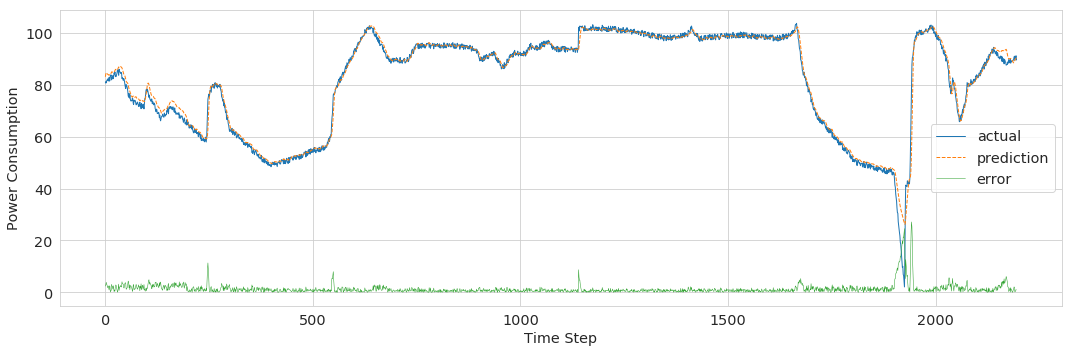

Calculated test loss 0.072913


In [4]:
import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(123)
rn.seed(123)
#single thread
session_conf = tf.ConfigProto(
intra_op_parallelism_threads=1,
inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(123)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import models.lstm as lstm
import configuration.config as cfg
import matplotlib

if cfg.run_config['Xserver'] == False:
    print "No X-server"
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
from keras.utils import plot_model
import utilities.utils as util
import numpy as np
import logging

# import plotly
# import plotly.plotly as py
# import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='aakashsingh', api_key='iMfR7hS1dbnmJ9XB17XO')

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style("whitegrid")


def make_plots(context,predictions_timesteps,true_values,look_ahead,title,path,save_figure,Xserver):
    step = 1
    if look_ahead > 1:
        step = look_ahead - 1
    for idx, i in enumerate(np.arange(0, look_ahead, step)):
        fig = plt.figure()
        #plt.title(title+" Timestep: %d "%i)
        plt.xlabel("Time Step")
        plt.ylabel("Power Consumption")
        plt.plot(true_values, label="actual", linewidth=1)
        plt.plot(predictions_timesteps[:, i], label="prediction", linewidth=1, linestyle="--")
        error = abs(true_values - predictions_timesteps[:, i])
        plt.plot(error, label="error", linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        if save_figure:
            util.save_figure(path,"%s_timestep_%d"%(context,i), fig)

    if Xserver:
        plt.show()



def get_predictions(context,model,X,y,train_scaler,batch_size,look_ahead,look_back,epochs,experiment_id):
    predictions = model.predict(X, batch_size=batch_size)
    print predictions.shape
    # rescale
    predictions = train_scaler.inverse_transform(predictions)
    y = train_scaler.inverse_transform(y)

    # extract first timestep for true values
    y_true = y[:, 0].flatten()

    # diagonals contains a reading's values calculated at different points in time
    diagonals = util.get_diagonals(predictions)

    # the top left and bottom right predictions do not contain predictions for all timesteps
    # fill the missing prediction values in diagonals. curenttly using the first predicted value for all missing timesteps
    for idx, diagonal in enumerate(diagonals):
        diagonal = diagonal.flatten()
        # missing value filled with the first value
        diagonals[idx] = np.hstack((diagonal, np.full(look_ahead - len(diagonal), diagonal[0])))
    predictions_timesteps = np.asarray(diagonals)
    
    print(y_true.shape, predictions_timesteps.shape)
    for i in range(look_ahead):
        logging.info("%s RMSE on %d timestep prediction %f" % ( context,
            (i + 1), mean_squared_error(y_true, predictions_timesteps[:, i]) ** 0.5))

    shifted_1 = util.shift_time_series(y_true, 1)

    logging.info(" %s RMSE Naive One Timestep Shift %f",context,
                 mean_squared_error(y_true[1:], shifted_1[1:]) ** 0.5)

    title = "Prediction on %s data. %d epochs, look back %d, look_ahead %d & batch_size %d." % (
                 context, epochs, look_back, look_ahead, batch_size)
    path = "%s/%s/"%("imgs",experiment_id)
    make_plots(context,predictions_timesteps,y_true,look_ahead,title,path,cfg.run_config['save_figure'],
               cfg.run_config['Xserver'])

    return predictions_timesteps, y_true
#load config settings
experiment_id = cfg.run_config['experiment_id']
data_folder = cfg.run_config['data_folder']
look_back = cfg.multi_step_lstm_config['look_back']
look_ahead = cfg.multi_step_lstm_config['look_ahead']
batch_size = cfg.multi_step_lstm_config['batch_size'] -(look_back+look_ahead) +1
epochs = cfg.multi_step_lstm_config['n_epochs']
dropout = cfg.multi_step_lstm_config['dropout']
layers = cfg.multi_step_lstm_config['layers']
loss = cfg.multi_step_lstm_config['loss']
# optimizer = cfg.multi_step_lstm_config['optimizer']
shuffle = cfg.multi_step_lstm_config['shuffle']
patience = cfg.multi_step_lstm_config['patience']
validation = cfg.multi_step_lstm_config['validation']
learning_rate = cfg.multi_step_lstm_config['learning_rate']
logging.info("----------------------------------------------------")
logging.info('Run id %s' % (experiment_id))

logging.info(" HYPERPRAMRAMS : %s" % (str(locals())))

train_scaler, X_train, y_train, X_validation1, y_validation1, X_validation2, y_validation2, validation2_labels, \
X_test, y_test, test_labels = util.load_data(data_folder, look_back, look_ahead)

#For stateful lstm the batch_size needs to be fixed before hand.
#We also need to ernsure that all batches shud have the same number of samples. So we drop the last batch as it has less elements than batch size
if batch_size > 1:
    n_train_batches = len(X_train)/batch_size
    len_train = n_train_batches * batch_size
    if len_train < len(X_train):
        X_train = X_train[:len_train]
        y_train = y_train[:len_train]

    n_validation1_batches = len(X_validation1)/batch_size
    len_validation1 = n_validation1_batches * batch_size
    if n_validation1_batches * batch_size < len(X_validation1):
        X_validation1 = X_validation1[:len_validation1]
        y_validation1 = y_validation1[:len_validation1]

    n_validation2_batches = len(X_validation2) / batch_size
    len_validation2 = n_validation2_batches * batch_size
    if n_validation2_batches * batch_size < len(X_validation2):
        X_validation2 = X_validation2[:len_validation2]
        y_validation2 = y_validation2[:len_validation2]

    n_test_batches = len(X_test)/batch_size
    len_test = n_test_batches * batch_size
    if n_test_batches * batch_size < len(X_test):
        X_test = X_test[:len_test]
        y_test = y_test[:len_test]

stateful_lstm = lstm.StatefulMultiStepLSTM(batch_size=batch_size, look_back=look_back, look_ahead=look_ahead,
                                      layers=layers,
                                      dropout=dropout, loss=loss, learning_rate=learning_rate)
model = stateful_lstm.build_model()
if cfg.run_config['save_figure']:
    plot_model(model, to_file="imgs/%s_stateful_lstm.png"%(experiment_id), show_shapes=True, show_layer_names=True)
# train model on training set. validation1 set is used for early stopping
history = lstm.train_stateful_model(model, X_train, y_train, batch_size, epochs, shuffle, validation, (X_validation1, y_validation1),
                 patience)
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
if cfg.run_config['save_figure']:
    util.save_figure("%s/%s/"%("imgs",experiment_id), "train_errors" , fig)

validation2_loss = model.evaluate(X_validation2, y_validation2, batch_size=batch_size, verbose=2)
print "Validation2 Loss %s" % (validation2_loss)
logging.info("Validation2 Loss %s" % (validation2_loss))
test_loss = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print "Test Loss %s" % (test_loss)
logging.info("Test Loss %s" % (test_loss))

predictions_train, y_true_train = get_predictions("Train", model, X_train, y_train, train_scaler,
                                                           batch_size, look_ahead, look_back, epochs, experiment_id,
                                                           )
np.save(data_folder + "train_predictions", predictions_train)
np.save(data_folder + "train_true",y_true_train)


predictions_validation1, y_true_validation1 = get_predictions("Validation1", model, X_validation1, y_validation1,
                                                              train_scaler, batch_size, look_ahead, look_back,
                                                              epochs, experiment_id,
                                                              )
predictions_validation1_scaled = train_scaler.transform(predictions_validation1)
print "Calculated validation1 loss %f" % (mean_squared_error(
    np.reshape(y_validation1, [len(y_validation1), look_ahead]),
    np.reshape(predictions_validation1_scaled, [len(predictions_validation1_scaled), look_ahead])))

np.save(data_folder + "validation1_predictions", predictions_validation1)
np.save(data_folder + "validation1_true", y_true_validation1)



predictions_validation2, y_true_validation2 = get_predictions("Validation2", model, X_validation2, y_validation2,
                                                              train_scaler, batch_size, look_ahead, look_back,
                                                              epochs, experiment_id,
                                                             )
predictions_validation2_scaled = train_scaler.transform(predictions_validation2)
print "Calculated validation2 loss %f"%(mean_squared_error(
    np.reshape(y_validation2, [len(y_validation2), look_ahead]),
    np.reshape(predictions_validation2_scaled, [len(predictions_validation2_scaled), look_ahead])))

np.save(data_folder + "validation2_predictions", predictions_validation2)
np.save(data_folder + "validation2_true", y_true_validation2)
np.save(data_folder + "validation2_labels", validation2_labels)

predictions_test, y_true_test = get_predictions("Test", model, X_test, y_test, train_scaler, batch_size, look_ahead,
                                                look_back, epochs, experiment_id,
                                               )
predictions_test_scaled = train_scaler.transform(predictions_test)
print "Calculated test loss %f" % (mean_squared_error( np.reshape(y_test, [len(y_test),look_ahead]),
                                   np.reshape(predictions_test_scaled, [len(predictions_test_scaled),look_ahead])))

np.save(data_folder + "test_predictions", predictions_test)
np.save(data_folder + "test_true", y_true_test)
np.save(data_folder + "test_labels", test_labels)
logging.info("-------------------------run complete----------------------------------------------")

   